In [204]:
# -*- coding: utf-8 -*-
"""
Created on Wed Nov 13 2024
@author: Ishaan Shah (phw6bv)
"""
import scipy
import numpy as np
import pandas as pd
import NetfluxODE_params as params
import NetfluxODE as file
import matplotlib.pyplot as plt

[speciesNames, tau, ymax, y0, w, n, EC50] = params.loadParams()
print(speciesNames)
print(len(speciesNames))

y0   = np.asarray(y0, dtype=float)
tau  = np.asarray(tau, dtype=float)

#production capacity for maximum stimulation
ymax = np.asarray(ymax, dtype=float)
w    = np.asarray(w,    float)
n    = np.asarray(n, dtype=float)
EC50 = np.asarray(EC50, dtype=float)
print(ymax)

# ymax *= 0.5
# print(f"Updated ymax: {ymax}")

['PIK3CA', 'ROS', 'Rock2', 'KLF2', 'CCM3', 'MIF', 'NFkB', 'CCM1', 'MEKK3', 'MEK5', 'ERK5', 'NOTCH', 'HEY1', 'HEY2', 'TSP1', 'Thbs1', 'TGFb', 'LGALS3BP', 'GAL3', 'GAL3ACT', 'CCND1', 'MMP9', 'eNOS', 'NO', 'HIF1alpha', 'Ang1', 'Tie2', 'PI3k', 'Akt', 'mTORC1', 'E4BP1', 'eIF4E', 'glutamate', 'GLAST', 'GLT1', 'Cd74', 'MCP1', 'IL18', 'IL1B', 'caspase1', 'NLRP3', 'COX2', 'VEGF', 'GLEXC', 'ANG', 'INFL', 'ASTRPROF', 'HEM']
48
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


## Steady State before CCM

In [205]:
#40 time units that displays the activity of each gene before any perturbation in a normal interaction

tspan = [0.0, 40.0] 
t_eval = np.linspace(tspan[0], tspan[1], 401)

sol_dict = {}
t_list = []
y_list = []

# sol = scipy.integrate.solve_ivp(file.ODEfunc,tspan,y0,args=(tau,ymax,w,n,EC50,))

sol = scipy.integrate.solve_ivp(
    file.ODEfunc,
    tspan,
    y0,
    args=(tau, ymax, w, n, EC50),
    # method="BDF",               # better for stiff systems
    atol=1e-8, rtol=1e-6,       # tighter tolerances
    t_eval=t_eval,              # fixed grid for plotting, although calculation is adaptive inside ode
    max_step=1.0               
)


# sol_dict[1] = sol
# t_list.append(sol.t)
# y_list.append(sol.y)

# #combines arrays into a single list or relative lists
# t = np.hstack(t_list)
# y = np.hstack(y_list)

# #turns y into a timepoints vector by row
# y_plot = y.T
y_plot = sol.y
t = sol.t
ss = y_plot[:, -1] # steady state
print(ss)
# print(ymax)

#make sure its settled near steady state
window = max(2, y_plot.shape[1] // 10)  # last 10% of trajectory
delta  = np.max(np.abs(y_plot[:, -1] - y_plot[:, -window]))
if delta > 1e-4:
    print(f"Warn: Δ={delta:.2e}, extend tspan.")


[0.3        0.3        0.3        0.3        0.3        0.3
 0.3        0.3        0.24444689 0.18849092 0.13433637 0.24444689
 0.18849092 0.18849092 0.18849092 0.24444689 0.34594516 0.79993948
 0.24444689 0.13861479 0.08917416 0.08917416 0.8192516  0.75223351
 0.87528997 0.65555311 0.60328276 0.91061332 0.82913708 0.76077341
 0.70063377 0.6456775  0.76652736 0.24444689 0.77381291 0.24444689
 0.92565963 0.32417847 0.68213811 0.37749701 0.42913951 0.83764907
 0.85574361 0.70579182 0.96237254 0.99000943 0.04895866 0.04895866]


## Steady State after Endothelial Cell Interactions

In [206]:
# #new steady state based on start of CCM from endothelial cells

# #go through each input manually since they could go either way

# #KLF2
# ymax[0] = 0.75

# #ROS
# ymax[1] = 0.75

# #PIK3CA
# ymax[2] = 0.75

# #CCM3
# ymax[3] = 0

# #Rock2
# ymax[4] = 0.75

# #MIF
# ymax[5] = 0.75

# #NFkB
# ymax[6] = 0.75

# #CCM1
# ymax[7] = 0

# tspan = [0, 40] 

# sol_dict = {}
# t_list = []
# y_list = []

# sol = scipy.integrate.solve_ivp(file.ODEfunc,tspan,y0,args=(tau,ymax,w,n,EC50,))
# sol_dict[1] = sol
# t_list.append(sol.t)
# y_list.append(sol.y)

# t = np.hstack(t_list)
# y = np.hstack(y_list)

# y_plot = y.T

# ss = y_plot[-1,:] # steady state
# print(ss)
# print(ymax)

## Find the effects of each gene on a target symptom (Mechanistic Analysis)

Knockdown each gene individually and compare its new activity with that of the steady state. This block keeps track of the changes upon a certain chosen symptom based on each knockdown. 

In [207]:
"""
Ways to update: 
Threading/Parallel processing when more nodes are there
change the output 'continue' to be at the top so we dont do entire calc for outputs
"""

#first middle and output node in the network 
first_middle = 8
first_output = 43 #check netflux ODE for this (UPDATE WHEN NECESSARY)

def gene_effect_on_symptom(symptom):
    #keep track of each gene's effect on the symptom in question
    change_in_symptom = {}
    num_species = len(speciesNames)

    #loop through all genes
    for i in range(0, num_species):
        # Copy ymax and set the current biomolecule's ymax to 0 (simulate knockdown)
        #print(speciesNames[i])
        ymax_knockdown = ymax.copy()
        ymax_knockdown[i] = 0

        # Run the simulation with the knockdown
        # sol2_dict = {}
        # t2_list = []
        # y2_list = []
        # sol2 = scipy.integrate.solve_ivp(file.ODEfunc,tspan,y0,args=(tau,ymax_knockdown,w,n,EC50,))
        sol2 = scipy.integrate.solve_ivp(
            file.ODEfunc,
            tspan,
            y0,
            args=(tau, ymax_knockdown, w, n, EC50),
            rtol=1e-6,
            atol=1e-8,
            t_eval=t_eval
        )
        # sol2_dict[1] = sol2
        # t2_list.append(sol2.t)
        # y2_list.append(sol2.y)

        # t2 = np.hstack(t2_list)
        # y2 = np.hstack(y2_list)
        y_knock_plot = sol2.y
        t_knock_post = sol2.t

        ss_perturbation = y_knock_plot[:, -1]  # steady-state values at the end of the simulation

        # Calculate the change in activity for the tracked biomolecule due to the knockdown
        change_in_activity = ss_perturbation[symptom] - ss[symptom]

        # Store the result in the dictionary with the gene name as the key
        #stop at the first output, to not key in the outputs
        if i >= first_output: #change this later to be more efficient, cuz calc not needed
            change_in_symptom[speciesNames[i]] = 0
        else:
            change_in_symptom[speciesNames[i]] = change_in_activity

    sorted_change = dict(sorted(change_in_symptom.items(), key=lambda item: item[1]))
    return sorted_change   
    #sorted_change is a sorted dictionary for changes in activity for a symptom while each node is knocked down 

In [208]:
def plot_change(sorted_change, symptom, symptom_name):
    sorted_change_df = pd.DataFrame(list(sorted_change.items()), columns=['Genes', 'Change in Activity of Symptom'])
    # print(sorted_change_df)

    plt.figure(figsize=(10, 6))
    plt.bar(sorted_change_df['Genes'], sorted_change_df['Change in Activity of Symptom'])
    plt.xticks(rotation=90)
    plt.xlabel(f'{symptom_name}')
    plt.ylabel(f'Change in Activity for {symptom_name}')
    plt.title(f'Effect of single-gene knockdowns on {speciesNames[symptom]}')
    plt.tight_layout()
    plt.show()

## Important files

In [209]:
#UNIFORM COST SEARCH
#get the model Excel and retrieve all the species for nodes, and reactions for edges
#verify that it works in Netflux first, unless you want to add checks here

networkName = "CCMNetIS.xlsx"  #network excel
species_sheet = "species" #sheet in the excel
reaction_sheet = "reactions" #another sheet in the excel

species_df = pd.read_excel(networkName, sheet_name = species_sheet, header = 1)
reactions_df = pd.read_excel(networkName, sheet_name = reaction_sheet, header = 1)

# Inspect the first few rows to ensure it's loaded correctly
print(species_df.head())

   module      ID                              name  Yinit  Ymax  tau  \
0  inputs  PIK3CA                            PIK3CA      0     1    1   
1  inputs     ROS           Reactive Oxygen Species      0     1    1   
2  inputs   Rock2                      Angiogenesis      0     1    1   
3  inputs    KLF2  Kruppel like trancription factor      0     1    1   
4  inputs    CCM3                              CCM3      0     1    1   

            type  location Gene Name  \
0        protein       NaN    PIK3CA   
1  smallMolecule       NaN       ROS   
2        protein       NaN     Rock2   
3        protein       NaN      KLF2   
4        protein       NaN       NaN   

                                            Function  \
0                                 Cell proliferation   
1     Free radicals reacting with stuff it shouldn't   
2  Mutation in CCM, which usuallly inactivates Rh...   
3  regulation of monocytes and endothelial cells,...   
4                              Mutation 

In [210]:
#show that it displays what you want(reactions in this case)
reactions_df.drop([0], inplace=True)
print(reactions_df.head())

   module  ID       Rule  Weight    n  EC50  confidence 1  species 1 Mutation  \
1  inputs  i1    => KLF2     0.3  1.4   0.5           NaN        NaN     CCM3   
2  inputs  i2     => ROS     0.3  1.4   0.5           NaN        NaN     CCM3   
3  inputs  i3  => PIK3CA     0.3  1.4   0.5           NaN        NaN  its own   
4  inputs  i4    => CCM3     0.3  1.4   0.5           NaN        NaN     CCM3   
5  inputs  i5   => Rock2     0.3  1.4   0.5           NaN        NaN  All CCM   

  Initial Change  ... database 1 ref ID 1  \
1    Upregulated  ...        NaN      NaN   
2    upregulated  ...        NaN      NaN   
3    Upregulated  ...        NaN      NaN   
4    Knocked out  ...        NaN      NaN   
5    upregulated  ...        NaN      NaN   

                                              link 1  \
1  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8...   
2  https://www.ahajournals.org/doi/10.1161/CIRCRE...   
3  https://www.sciencedirect.com/science/article/...   
4  https://www.sci

## Make the network in python

In [211]:
import networkx as nx
import re

#makes and displays the signaling network
def make_signaling_network(reactions_df, sorted_change, keep_modules=("middle","output","outputs")):
    signaling_network = nx.DiGraph()
    eps = 1e-9 #floor is not 0
    
    for index, row in reactions_df.iterrows():
        #inputs dont need to be added individually to the network as they dont have a reaction, product pair
        if str(row.get('module', '')).strip().lower() == 'inputs':
            continue

        #grab the reaction column with =>
        reaction = row.get('Rule')
        if not isinstance(reaction, str) or '=>' not in reaction:
            continue

        # split into (reactants) and (product)
        left, right = reaction.split('=>', 1)
        left  = left.strip()
        right = right.strip()

        # parse product, track negation, then strip "!" for value
        prod_neg = right.startswith('!')
        product  = right.lstrip('!').strip().strip('()')

        if not product:
            continue  # dont put an edge to nothing

        # split reactants by '&' and put them in array
        reactant_tokens = [tok.strip() for tok in left.split('&') if tok.strip()]

        # add edges reactant -> product; preserve sign for inhibition (!)
        for tok in reactant_tokens:
            react_neg = tok.startswith('!')
            reactant  = tok.lstrip('!').strip().strip('()')
            if not reactant:
                continue

            # compose sign: negative reactant flips, negative product flips
            sign = (-1 if react_neg else 1) * (-1 if prod_neg else 1)

            signaling_network.add_edge(reactant, product)
            signaling_network[reactant][product]['sign'] = sign
            signaling_network[reactant][product]['rule_row'] = int(index)

    #trying to keep all weights positive, so shifting by the most negative value
    try:
        dmin = min(float(v) for v in sorted_change.values())
    except ValueError:
        dmin = 0.0  # empty dict fallback

    base_shift = max(0.0, -dmin)  # makes the best (most negative) delta map to ~eps


    #attach edge costs (UCS expects non-negative)
    for (reactant, product) in signaling_network.edges:
        # get the changes in gene activity, default to 0.0 if missing to avoid KeyError
        reactant_delta = float(sorted_change.get(reactant, 0.0))
        product_delta  = float(sorted_change.get(product, 0.0))

        # map “effect” -> “cost”: if goal is to MINIMIZE the symptom,
        # larger negative product_delta should be CHEAPER
        cost = max(eps, -product_delta + base_shift)

        signaling_network[reactant][product]['cost'] = cost
        signaling_network[reactant][product]['delta_reactant'] = reactant_delta
        signaling_network[reactant][product]['delta_product']  = product_delta

    return signaling_network



    # # Add costs to edges by taking average effect of product and reactant on symptom
    # for (reactant, product) in signaling_network.edges:
    #     reactant_cost = sorted_change[reactant]
    #     product_cost = sorted_change[product]
    #     # print(reactant_cost)
    #     # print(product_cost)
    #     cost = (reactant_cost + product_cost)/2
    #     # if product == 'ANG':
    #     #     cost = reactant_cost
    #     # print(cost)
    #     signaling_network[reactant][product]['cost'] = cost

    # # Verify by printing edges with costs
    # # print("Edge Costs:")
    # # for u, v, data in signaling_network.edges(data=True):
    # #     print(f"({u} -> {v}): {data}")
    # return signaling_network


In [212]:
#displays the network
# def display_network(signaling_network):
#     plt.figure(figsize=(10, 8))
#     nx.draw(signaling_network, with_labels=True, node_size=2000, node_color='lightblue', font_size=10, font_weight='bold', arrowstyle="->", arrowsize=15)
#     plt.title("Species Reaction Network")
#     plt.show()
def display_network(signaling_network, show_costs=False):
    plt.figure(figsize=(14, 10))
    
    pos = nx.spring_layout(signaling_network, seed=42, k=0.5)
    
    #color edge by their sign
    pos_edges = [(u, v) for u, v, d in signaling_network.edges(data=True) if d.get("sign", 1) > 0]
    neg_edges = [(u, v) for u, v, d in signaling_network.edges(data=True) if d.get("sign", 1) < 0]
    
    nx.draw_networkx_nodes(signaling_network, pos, node_color="lightblue", node_size=2000)
    nx.draw_networkx_labels(signaling_network, pos, font_size=9, font_weight="bold")
    
    nx.draw_networkx_edges(signaling_network, pos, edgelist=pos_edges,
                           edge_color="green", arrows=True, arrowstyle="->", arrowsize=15)
    nx.draw_networkx_edges(signaling_network, pos, edgelist=neg_edges,
                           edge_color="red", arrows=True, arrowstyle="->", arrowsize=15)
    
    if show_costs:
        edge_labels = {(u, v): f"{d['cost']:.2f}" for u, v, d in signaling_network.edges(data=True)}
        nx.draw_networkx_edge_labels(signaling_network, pos, edge_labels=edge_labels, font_size=7)
    
    plt.title("Species Reaction Network")
    plt.axis("off")
    plt.show()

## Uniform Cost Search

In [213]:
# #actual uniform cost search based on path that decreases angiogenesis the most

# #Starts at source and ends at target
# #finds shortest path by keeping track of cumulative changes to angiogenesis
# #networkx uses a similar algorithm taking cost into account (default is djikstra)
# #bell man ford used since there are negative weights

# #function to run shortest path with negative cycles accounted for
# def find_best_treatment_path(signaling_network, source, target, weight):
#     try:
#         # Check for negative weight cycles in the graph
#         if nx.negative_edge_cycle(signaling_network, weight):
#             print("Graph contains a negative weight cycle.")
            
#             # Modified Bellman-Ford to account for cycles
#             visited = set()
#             def custom_bellman_ford(signaling_network, source, target, weight):
#                 path = []
#                 current_gene = source
#                 while current_gene not in visited:
#                     visited.add(current_gene)
#                     path.append(current_gene)
#                     # Get neighbors and their weights
#                     neighbors = signaling_network[current_gene]
#                     next_gene, min_cost = None, float('inf')
#                     for neighbor, edge in neighbors.items():
#                         if neighbor in visited:
#                             continue  # Skip visited nodes
#                         edge_cost = edge.get(weight, float('inf'))
#                         if edge_cost < min_cost:
#                             next_gene, min_cost = neighbor, edge_cost
#                     if next_gene is None or current_gene == target:
#                         break  # Stop if no further path or target reached
#                     current_gene = next_gene
#                 if target not in path:
#                     raise nx.NetworkXNoPath(f"No path from {source} to {target}")
#                 return path

#             path = custom_bellman_ford(signaling_network, source, target, weight)
#             path_cost = sum(signaling_network[u][v]["cost"] for u, v in zip(path[:-1], path[1:]))
#         else:
#             path = nx.shortest_path(signaling_network, source, target, weight, method="bellman-ford")
#             print(len(path))
#             path_cost = nx.shortest_path_length(signaling_network, source, target, weight, method="bellman-ford")
#     except nx.NetworkXNoPath:
#         print("No path found between specified nodes.")
#         return None, None
#     return path, path_cost

In [ ]:
#IMPROVEMENTS: 
#add in multiple cycles to affect rest of cascade, currently does not take cycles into account

# #actual uniform cost search based on path that decreases angiogenesis the most

# #Starts at source and ends at target
# #finds shortest path by keeping track of cumulative changes to angiogenesis
# #networkx uses a similar algorithm taking cost into account (default is djikstra)
# #bell man ford used since there are negative weights

#make sure cost is established
def find_best_treatment_path(signaling_network, source, target, weight: str = "cost",):
    #makes sure nodes exist
    if source not in signaling_network or target not in signaling_network:
        print(f"Either source '{source}' or target '{target}' not in graph.")
        return None, None

    # detect if there are any negative weight edges
    has_negative = False
    for u, v, d in signaling_network.edges(data=True):
        w = d.get(weight, None)
        if w is None:
            print(f"Warning: edge ({u}->{v}) missing weight '{weight}'. Treating as +inf.")
            signaling_network[u][v][weight] = float("inf")
            w = float("inf")
        if w < 0:
            has_negative = True

    try:
        if has_negative:
            # check for negative cycles first
            if nx.negative_edge_cycle(signaling_network, weight=weight):
                raise nx.NetworkXUnbounded(
                    f"Graph has a negative-weight cycle under '{weight}'; shortest path undefined."
                )
            path = nx.bellman_ford_path(signaling_network, source, target, weight=weight)
            total_cost = nx.bellman_ford_path_length(signaling_network, source, target, weight=weight)
        else:
            path = nx.shortest_path(signaling_network, source=source, target=target, weight=weight, method="dijkstra")
            total_cost = nx.shortest_path_length(signaling_network, source=source, target=target, weight=weight, method="dijkstra")

    except nx.NetworkXNoPath:
        print(f"No path found from '{source}' to '{target}'.")
        return None, None
    except nx.NetworkXUnbounded as e:
        print(str(e))
        return None, None
    return path, total_cost


## Outputs

In [215]:
#symptoms written as their indexes in parameters
glutamate_excitotoxicity = 43
angiogenesis = 44
neuroinflammation = 45
astrocyte_proliferation = 46
hemorrhage = 47

## Angiogenesis

c:\Users\ishah\OneDrive\Documents\Price Lab Research\generate drug list\generate drug list\NetfluxODE.py:117: RuntimeWarning: invalid value encountered in scalar power
  fact = w*(beta*x**n)/(K**n+x**n)


{'HIF1alpha': -0.5116904041842842, 'Akt': -0.42799568211595074, 'PI3k': -0.4279956368178246, 'VEGF': -0.13616582210114803, 'COX2': -0.12461716175048654, 'NO': -0.12120096507690337, 'eNOS': -0.12120096188046858, 'eIF4E': -0.056370275283391, 'mTORC1': -0.0563702063629512, 'E4BP1': -0.05637016937834216, 'LGALS3BP': -0.03552024103104845, 'Ang1': -0.03079890100826632, 'Tie2': -0.030798898505456807, 'CCM1': -0.015244253604118185, 'NOTCH': -0.01258444494607236, 'KLF2': -0.008057199063426723, 'HEY1': -0.005839149925876641, 'HEY2': -0.005839149925876641, 'Cd74': -0.005303696286922066, 'MIF': -0.00530369628078553, 'TSP1': -0.003318233386490288, 'Thbs1': -0.003318233140531479, 'PIK3CA': -0.002285787678529161, 'ROS': -0.0020881147809779232, 'GAL3ACT': -0.002087934847558981, 'GAL3': -0.0020879242769412665, 'MEKK3': -0.001993187328504953, 'MEK5': -0.001993181622613527, 'ERK5': -0.001993181038646208, 'glutamate': -1.5523645036097378e-08, 'caspase1': -1.499445778652131e-08, 'CCND1': -1.247725733843907

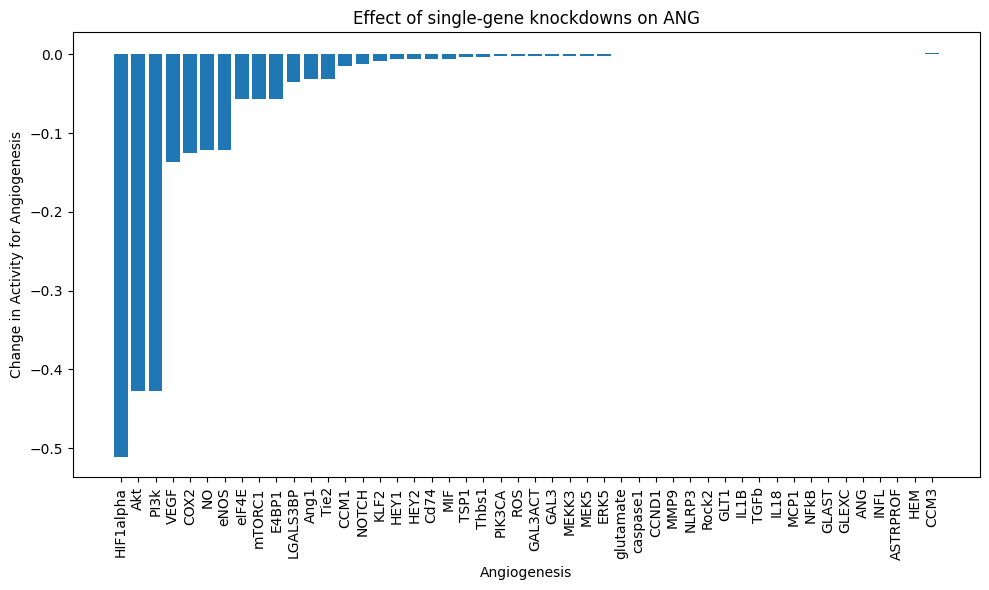

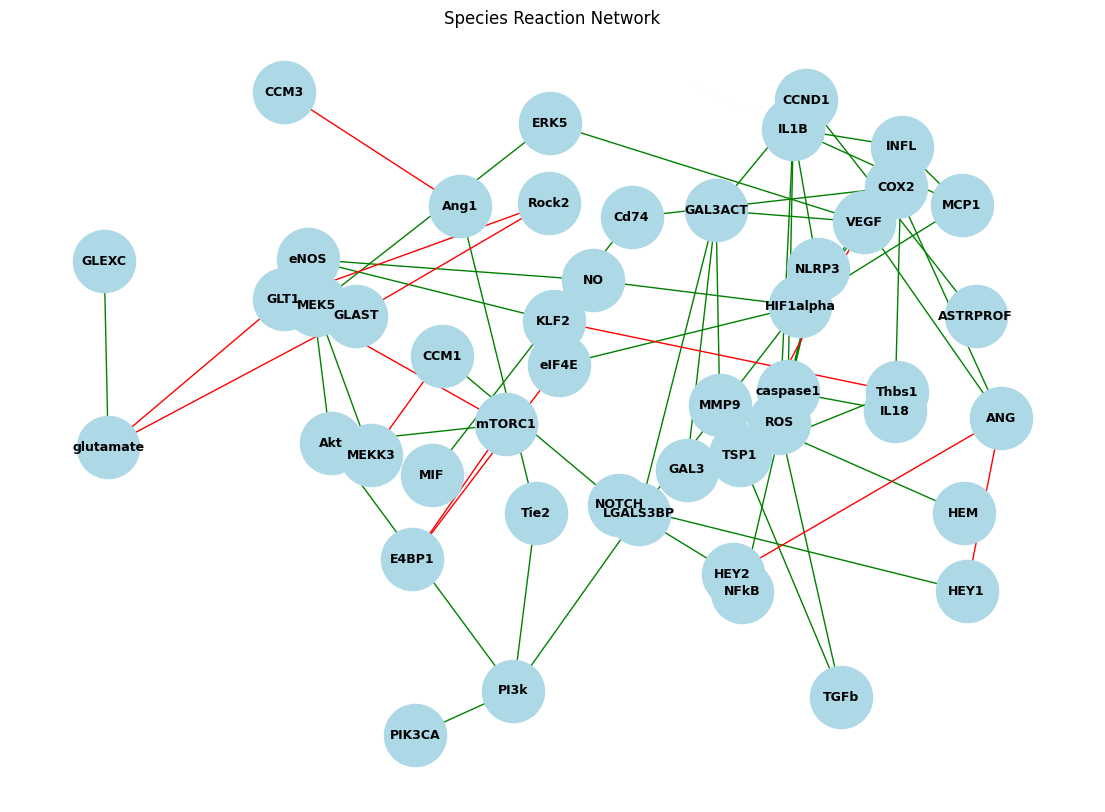

In [216]:
ANG_sorted_change = gene_effect_on_symptom(angiogenesis)
print(ANG_sorted_change)
ANG_signaling_network = make_signaling_network(reactions_df, ANG_sorted_change)
ANG_best_path, ANG_best_path_cost = find_best_treatment_path(ANG_signaling_network, source="CCM3", target="ANG", weight="cost")
print("Shortest path for Angiogenesis based on cost:", ANG_best_path)
print("Total Angiogenesis path cost:", ANG_best_path_cost)
plot_change(ANG_sorted_change, angiogenesis, "Angiogenesis")
display_network(ANG_signaling_network)

In [217]:
ang_species = ANG_sorted_change.keys()
ang_values = ANG_sorted_change.values()
ANG_sorted_change_df = pd.DataFrame(ang_values, ang_species)
print(ANG_sorted_change_df)

                      0
HIF1alpha -5.116904e-01
Akt       -4.279957e-01
PI3k      -4.279956e-01
VEGF      -1.361658e-01
COX2      -1.246172e-01
NO        -1.212010e-01
eNOS      -1.212010e-01
eIF4E     -5.637028e-02
mTORC1    -5.637021e-02
E4BP1     -5.637017e-02
LGALS3BP  -3.552024e-02
Ang1      -3.079890e-02
Tie2      -3.079890e-02
CCM1      -1.524425e-02
NOTCH     -1.258444e-02
KLF2      -8.057199e-03
HEY1      -5.839150e-03
HEY2      -5.839150e-03
Cd74      -5.303696e-03
MIF       -5.303696e-03
TSP1      -3.318233e-03
Thbs1     -3.318233e-03
PIK3CA    -2.285788e-03
ROS       -2.088115e-03
GAL3ACT   -2.087935e-03
GAL3      -2.087924e-03
MEKK3     -1.993187e-03
MEK5      -1.993182e-03
ERK5      -1.993181e-03
glutamate -1.552365e-08
caspase1  -1.499446e-08
CCND1     -1.247726e-08
MMP9      -1.247726e-08
NLRP3     -9.824176e-09
Rock2     -9.342044e-09
GLT1      -9.197926e-09
IL1B      -8.562158e-09
TGFb      -3.856310e-09
IL18      -3.640603e-09
MCP1      -3.616585e-09
NFkB      -3.613

## Glutamate Excitotoxicity

c:\Users\ishah\OneDrive\Documents\Price Lab Research\generate drug list\generate drug list\NetfluxODE.py:117: RuntimeWarning: invalid value encountered in scalar power
  fact = w*(beta*x**n)/(K**n+x**n)


Shortest path for Glutamate Excitotoxicity based on cost: ['CCM3', 'Ang1', 'Tie2', 'PI3k', 'Akt', 'mTORC1', 'GLT1', 'glutamate', 'GLEXC']
Total Glutamate Excitotoxicity path cost: 8.359687478737241


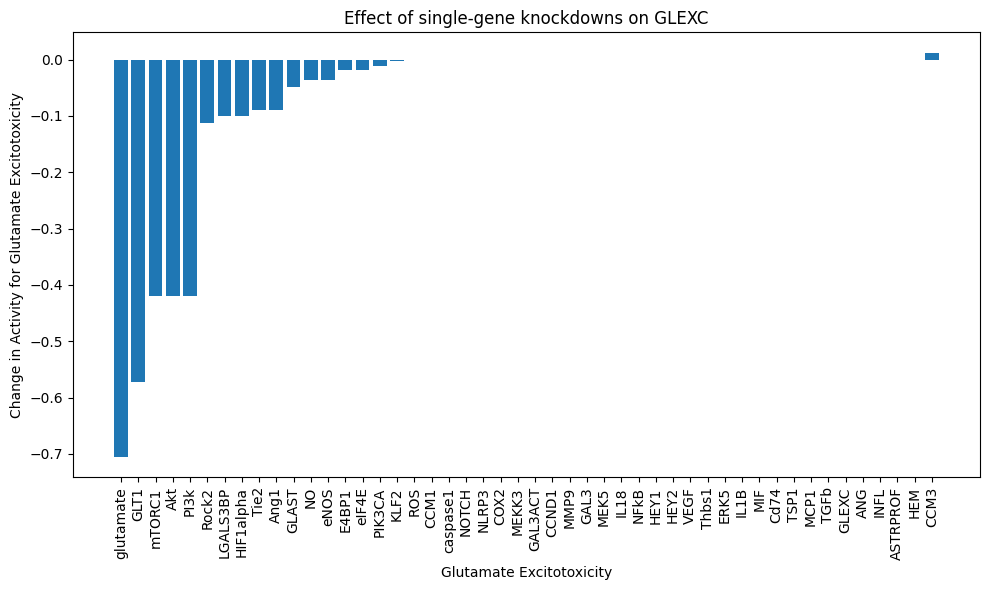

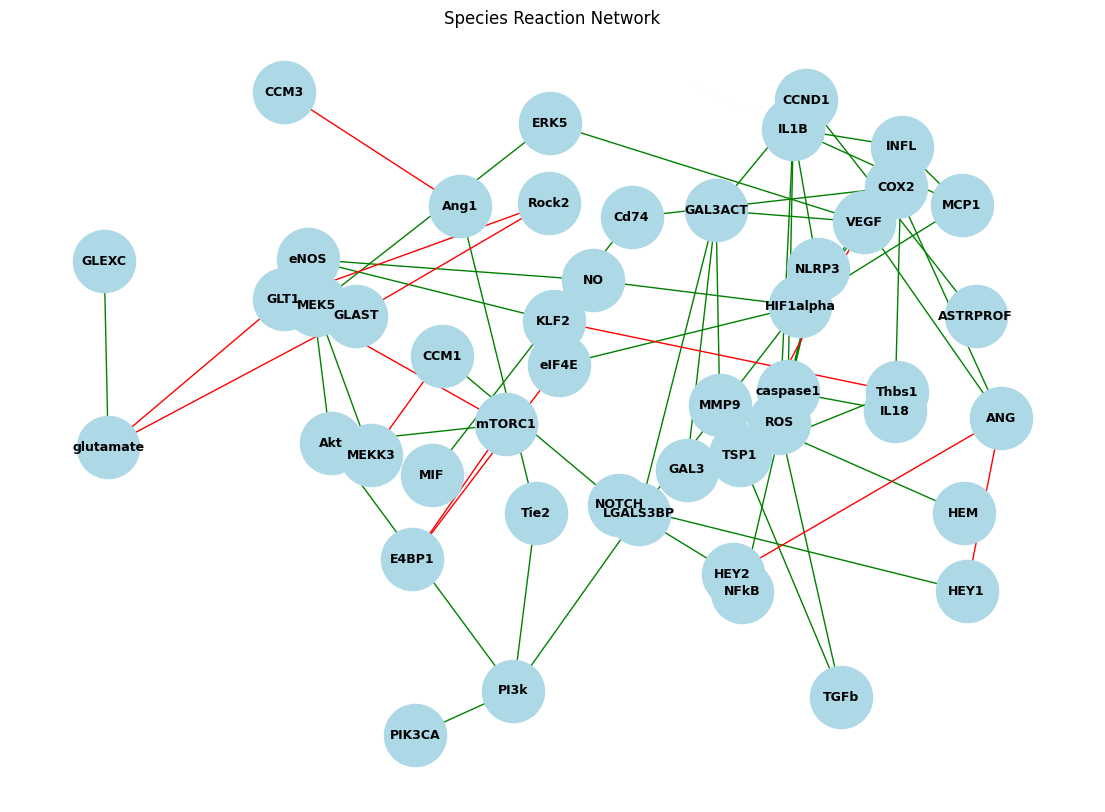

In [218]:
GLEXC_sorted_change = gene_effect_on_symptom(glutamate_excitotoxicity)
GLEXC_signaling_network = make_signaling_network(reactions_df, GLEXC_sorted_change)
GLEXC_best_path, GLEXC_best_path_cost = find_best_treatment_path(GLEXC_signaling_network, source="CCM3", target="GLEXC", weight="cost")
print("Shortest path for Glutamate Excitotoxicity based on cost:", GLEXC_best_path)
print("Total Glutamate Excitotoxicity path cost:", GLEXC_best_path_cost)
plot_change(GLEXC_sorted_change, glutamate_excitotoxicity, "Glutamate Excitotoxicity")
display_network(GLEXC_signaling_network)

## Neuroinflammation

Shortest path for Neuroinflammation based on cost: ['CCM3', 'Ang1', 'Tie2', 'PI3k', 'Akt', 'eNOS', 'NO', 'HIF1alpha', 'COX2', 'INFL']
Total Neuroinflammation path cost: 1.136733624398989


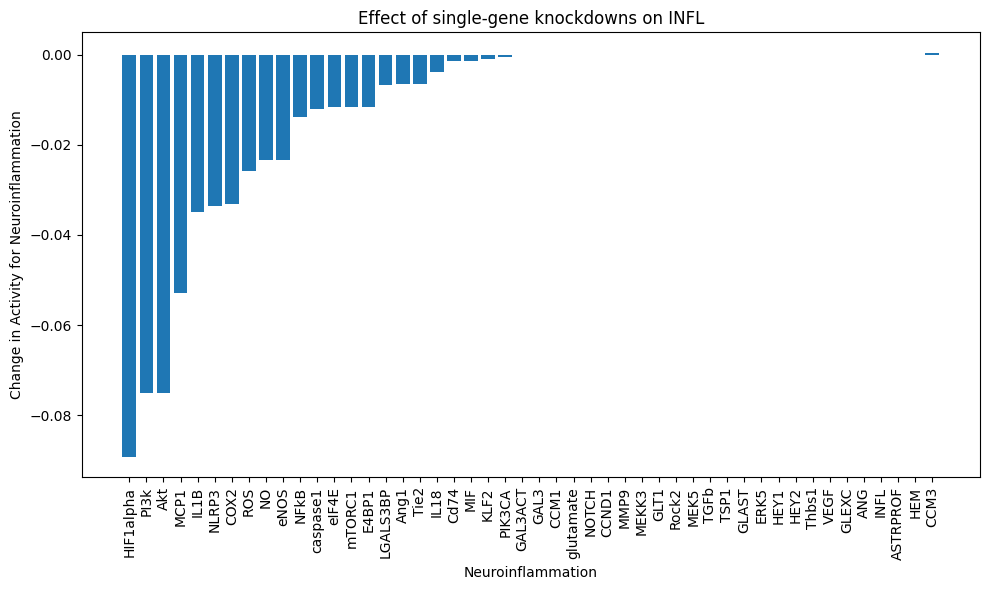

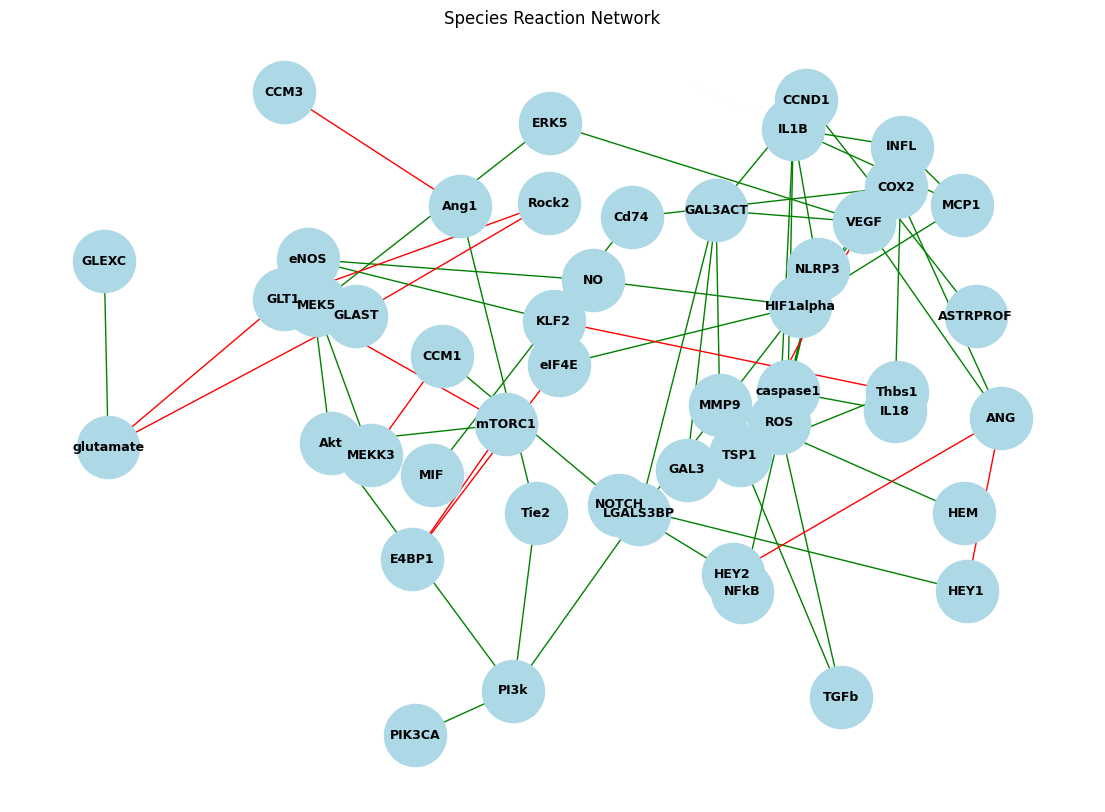

In [219]:
INFL_sorted_change = gene_effect_on_symptom(neuroinflammation)
INFL_signaling_network = make_signaling_network(reactions_df, INFL_sorted_change)
INFL_best_path, INFL_best_path_cost = find_best_treatment_path(INFL_signaling_network, source="CCM3", target="INFL", weight="cost")
print("Shortest path for Neuroinflammation based on cost:", INFL_best_path)
print("Total Neuroinflammation path cost:", INFL_best_path_cost)
plot_change(INFL_sorted_change, neuroinflammation, "Neuroinflammation")
display_network(INFL_signaling_network)

## Astrocyte Proliferation

Shortest path for Astrocyte Proliferation based on cost: ['CCM3', 'Ang1', 'Tie2', 'PI3k', 'Akt', 'eNOS', 'NO', 'HIF1alpha', 'LGALS3BP', 'GAL3ACT', 'CCND1', 'ASTRPROF']
Total Astrocyte Proliferation path cost: 0.9222851204784941


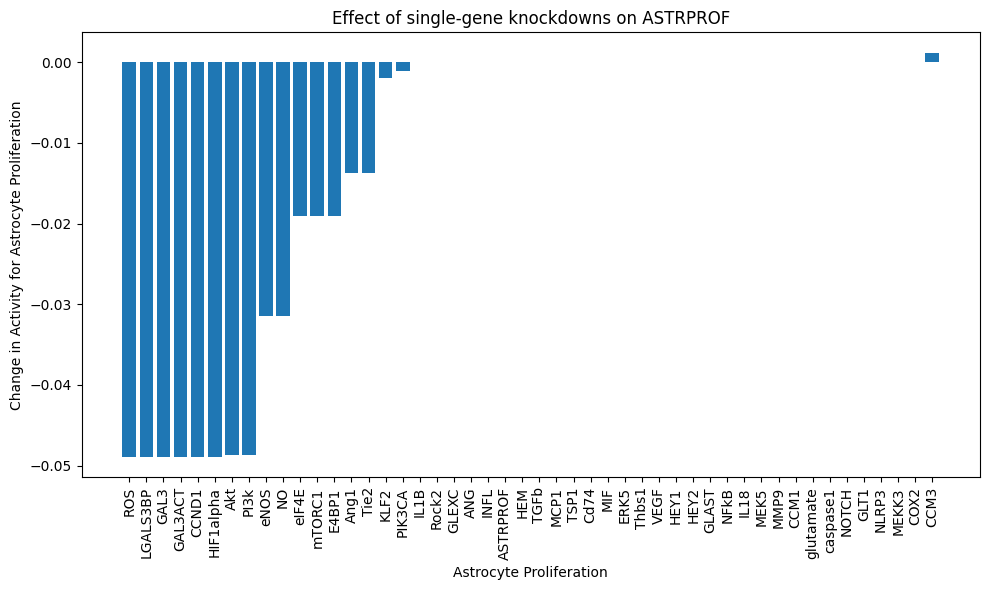

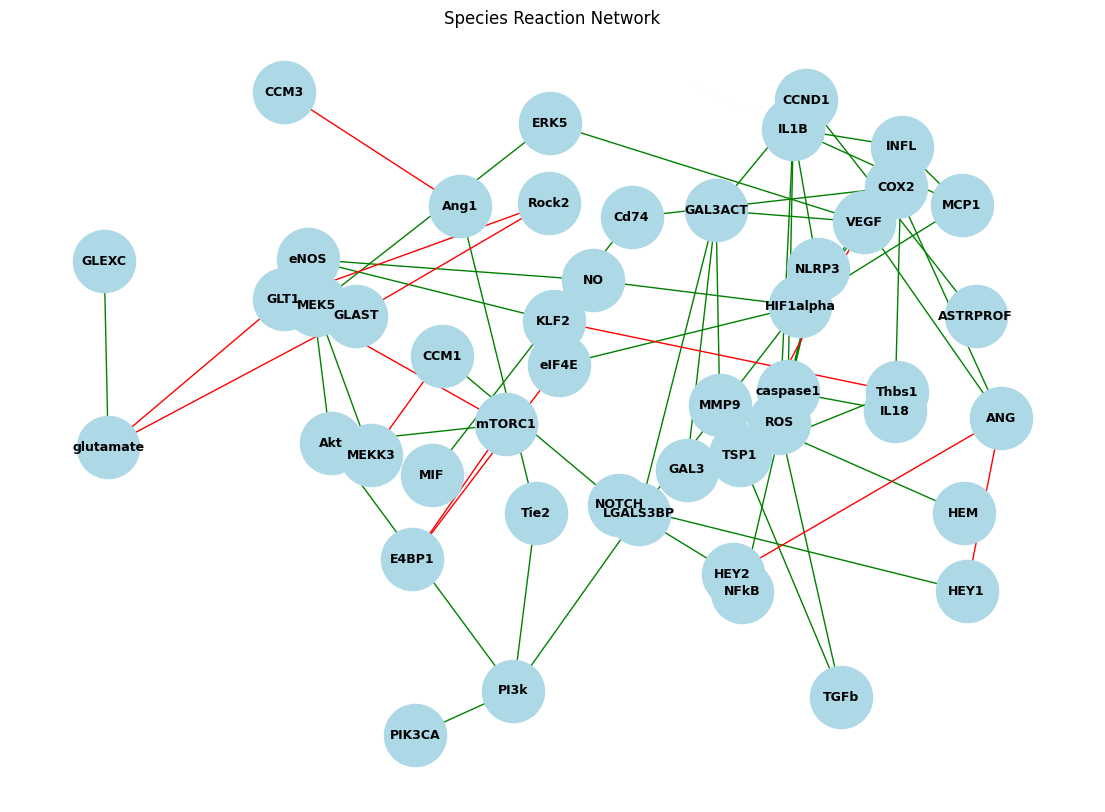

In [220]:
ASTRPROF_sorted_change = gene_effect_on_symptom(astrocyte_proliferation)
ASTRPROF_signaling_network = make_signaling_network(reactions_df, ASTRPROF_sorted_change)
ASTRPROF_best_path, ASTRPROF_best_path_cost = find_best_treatment_path(ASTRPROF_signaling_network, source="CCM3", target="ASTRPROF", weight="cost")
print("Shortest path for Astrocyte Proliferation based on cost:", ASTRPROF_best_path)
print("Total Astrocyte Proliferation path cost:", ASTRPROF_best_path_cost)
plot_change(ASTRPROF_sorted_change, astrocyte_proliferation, "Astrocyte Proliferation")
display_network(ASTRPROF_signaling_network)

## Hemorrhage

Shortest path for Hemorrhage based on cost: ['CCM3', 'Ang1', 'Tie2', 'PI3k', 'Akt', 'eNOS', 'NO', 'HIF1alpha', 'LGALS3BP', 'GAL3ACT', 'MMP9', 'HEM']
Total Hemorrhage path cost: 0.9222851204784941


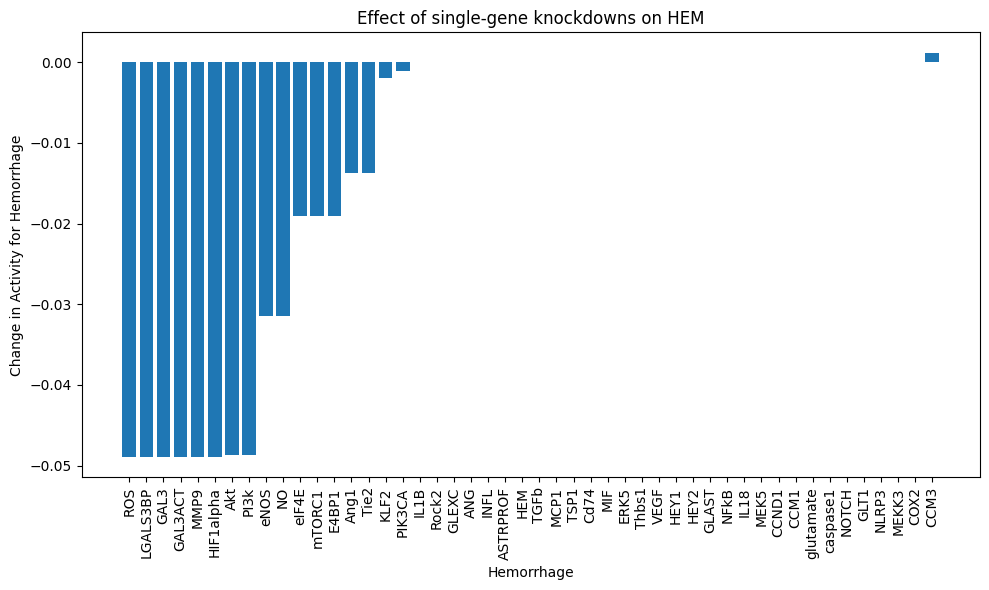

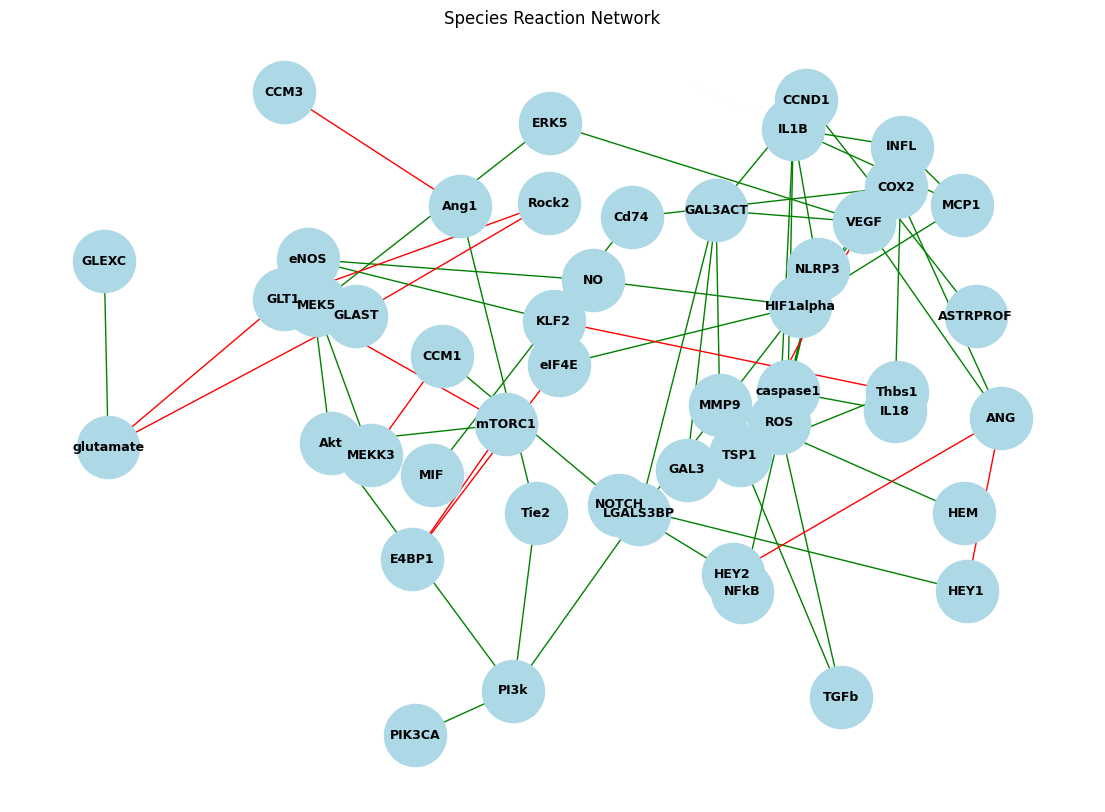

In [221]:
HEM_sorted_change = gene_effect_on_symptom(hemorrhage)
HEM_signaling_network = make_signaling_network(reactions_df, HEM_sorted_change)
HEM_best_path, HEM_best_path_cost = find_best_treatment_path(HEM_signaling_network, source="CCM3", target="HEM", weight="cost")
print("Shortest path for Hemorrhage based on cost:", HEM_best_path)
print("Total Hemorrhage path cost:", HEM_best_path_cost)
plot_change(HEM_sorted_change, hemorrhage, "Hemorrhage")
display_network(HEM_signaling_network)

Change validation to have increases and decreases
    -make validation figure

find more nodes for astrprof

further investigate common pathways seen as most efficient (expand it)

change source from CCM3
